<a href="https://colab.research.google.com/github/MaelaGLG/ML-for-econometrics/blob/main/notebooks/penalized_linear_models_sklearn_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
# We fetch the data from `OpenML <http://openml.org/>`_.
# Note that setting the parameter `as_frame` to True will retrieve the data
# as a pandas dataframe.
from sklearn.datasets import fetch_openml

adult_census_data = fetch_openml(data_id=1590, as_frame=True)

# c'est pas un dataframe mais un codebook

Inspection of the dataset

```{note}
We use the [Pandas](https://pandas.pydata.org/) Python library to work
manipulate 1 and 2 dimensional structured data. If you have never used
pandas, we recommend you look at this
[tutorial](https://pandas.pydata.org/docs/user_guide/10min.html).
```

In [5]:
# The adult_census_data object is a dictionary-like object which contains:
print(adult_census_data.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [6]:
# We can read a description of the dataset using the DESCR key of the
print(adult_census_data.DESCR)

**Author**: Ronny Kohavi and Barry Becker  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Adult) - 1996  
**Please cite**: Ron Kohavi, "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996  

Prediction task is to determine whether a person makes over 50K a year. Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

This is the original version from the UCI repository, with training and test sets merged.

### Variable description

Variables are all self-explanatory except __fnlwgt__. This is a proxy for the demographic background of the people: "People with similar demographic characteristics should have similar weights". This similarity-statement is not transferable across the 51 different states.

Description f

In [8]:
# Let's look at the dataframe itself
adult_census = adult_census_data.frame
# Print the dimensions and the first few rows of the dataframe
print(adult_census.shape)
adult_census.head()

(48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


# Focus on the target variable

In [9]:
# The target is the class variable: 'class'
target_name = "class"
y = adult_census[target_name]
adult_census[target_name].value_counts()

,count
class,
<=50K,37155
>50K,11687


```{note}
Here, classes are slightly imbalanced, meaning there are more samples of one
or more classes compared to others. In this case, we have many more samples
with `" <=50K"` than with `" >50K"`. Class imbalance happens often in practice
and may need special techniques when building a predictive model.

For example in a medical setting, if we are trying to predict whether subjects
may develop a rare disease, there would be a lot more healthy subjects than
ill subjects in the dataset.
```
# Visual inspection of the data

## Distinguish numerical and categorical columns
The dataset contains both numerical and categorical data. Numerical values take continuous values, for example "age". Categorical values can have a finite number of values, for example "native-country".

In [10]:
numerical_columns = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]
categorical_columns = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]
all_columns = numerical_columns + categorical_columns + [target_name]
adult_census = adult_census[all_columns]

## Display histograms for numerical columns
Let’s look at the distribution of individual features, to get some insights about the data. We can start by plotting histograms, note that this only works for features containing numerical values:

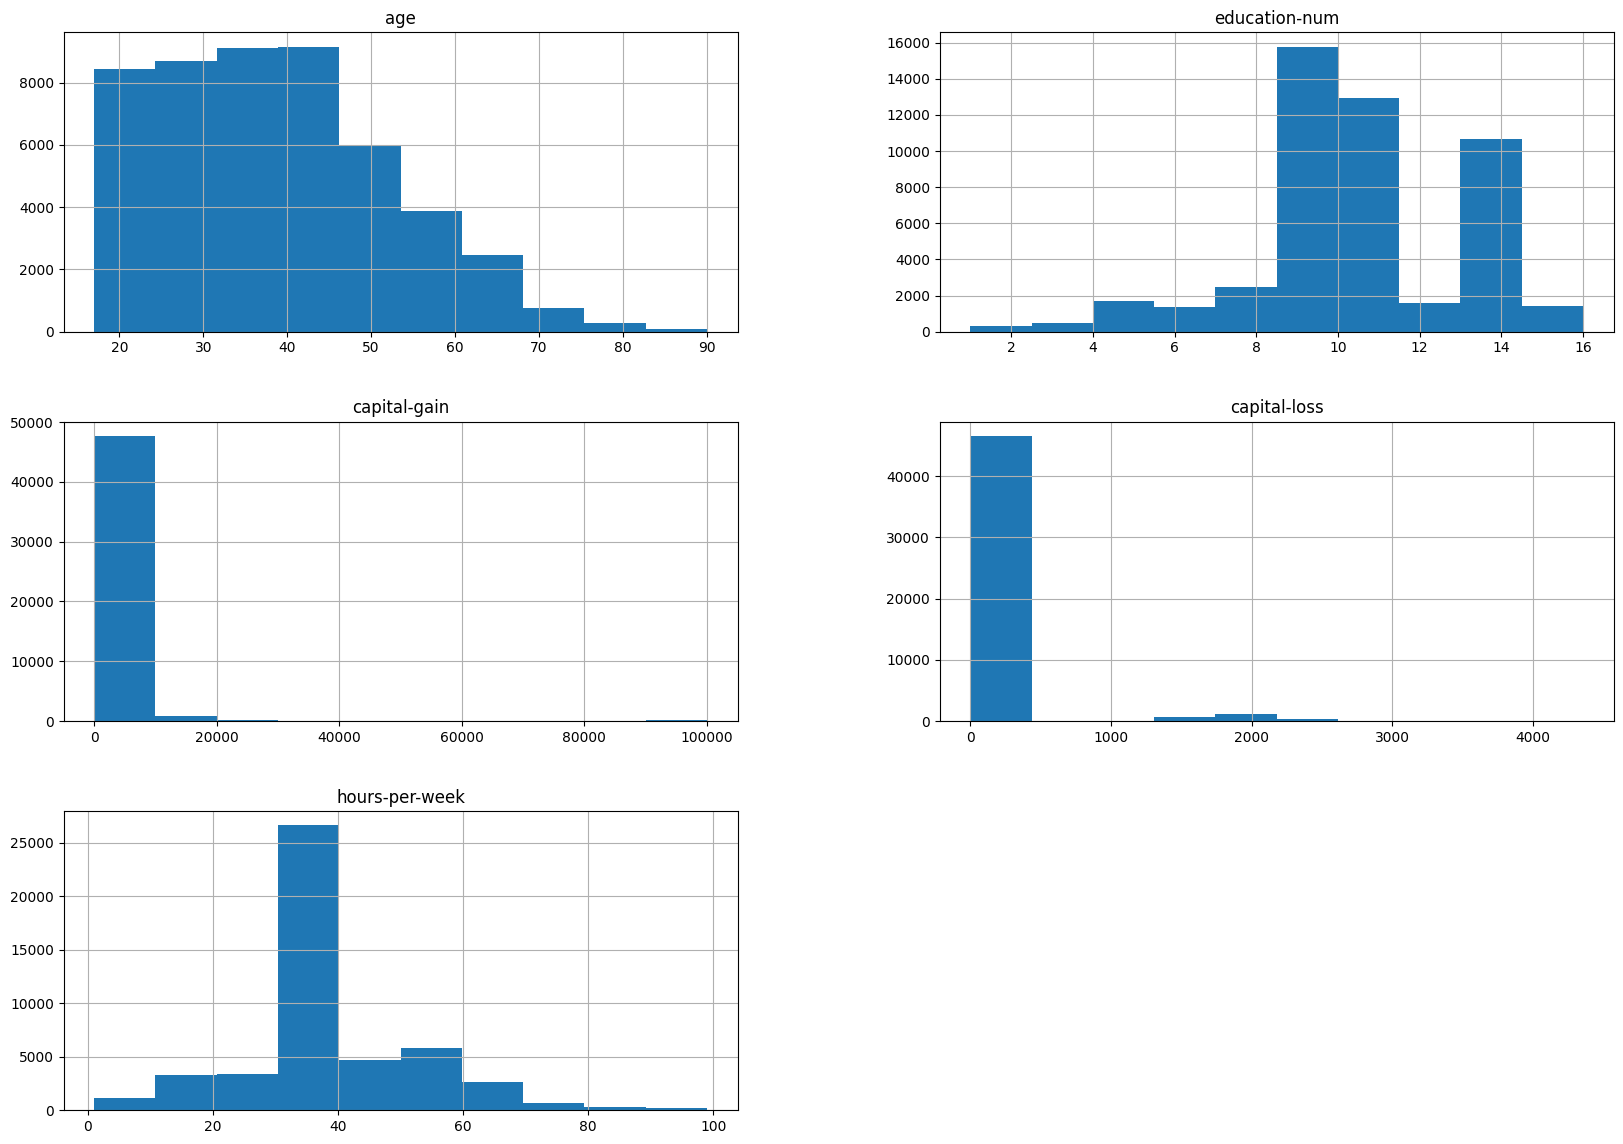

In [11]:
_ = adult_census.hist(figsize=(20, 14))

## Display the unique values of the categorical columns

In [12]:
adult_census["sex"].value_counts()

,count
sex,
Male,32650
Female,16192


Quite unbalanced!

In [13]:
adult_census["education"].value_counts()

,count
education,
HS-grad,15784
Some-college,10878
Bachelors,8025
Masters,2657
Assoc-voc,2061
11th,1812
Assoc-acdm,1601
10th,1389
7th-8th,955


As noted above, "education-num" distribution has two clear peaks around 10 and 13. It would be reasonable to expect that "education-num" is the number of years of education.

Let’s look at the relationship between "education" and "education-num".

In [14]:
pd.crosstab(index=adult_census["education"], columns=adult_census["education-num"])

education-num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,1389,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1812,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,657,0,0,0,0,0,0,0,0
1st-4th,0,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,509,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,955,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,756,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1601,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,2061,0,0,0,0,0


One-liner dataset inspection:

In [15]:
!pip install skrub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 16.0 MB/s eta 0:00:00


In [16]:
from skrub import TableReport
report = TableReport(adult_census)
report

,,,,,,,,,,,,,,


Build the predictive model
# Separate the target variable from the data

In [17]:
data = adult_census.drop(columns=[target_name])
data

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,25,7,0,0,40,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States
1,38,9,0,0,50,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States
2,28,12,0,0,40,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States
3,44,10,7688,0,40,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States
4,18,10,0,0,30,NaN,Some-college,Never-married,NaN,Own-child,White,Female,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,12,0,0,38,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States
48838,40,9,0,0,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
48839,58,9,0,0,40,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States
48840,22,9,0,0,20,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States


# Select only some numerical columns
For simplicity, we will select only the numerical columns in this dataset.


In [23]:
data_numeric = data[numerical_columns]
data_numeric

,age,education-num,capital-gain,capital-loss,hours-per-week
0,25,7,0,0,40
1,38,9,0,0,50
2,28,12,0,0,40
3,44,10,7688,0,40
4,18,10,0,0,30
...,...,...,...,...,...
48837,27,12,0,0,38
48838,40,9,0,0,40
48839,58,9,0,0,40
48840,22,9,0,0,20


## Separate training and testing data

In [24]:
from sklearn.model_selection import train_test_split

data_numeric_train, data_numeric_test, y_train, y_test = train_test_split(
    data_numeric, y, random_state=42
)
# ## First model

In [25]:
from sklearn.linear_model import LogisticRegression

# model declaration
model = LogisticRegression()
model

LogisticRegression()

In [26]:
# model fitting/training
_ = model.fit(data_numeric_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Remarks on fitting a model

# ![Predictor fit diagram](../slides/img/ML_1/api_diagram-predictor.fit.svg)
 In scikit-learn an object that has a fit method is called an estimator. The method fit is composed of two elements: (i) a learning algorithm and (ii) some model states. The learning algorithm takes the training data and training target as input and sets the model states. These model states are later used to either predict (for classifiers and regressors) or transform data (for transformers).

In [27]:
# model prediction
y_train_predicted = model.predict(data_numeric_train)

# ![Predictor predict diagram](../slides/img/ML_1/api_diagram-predictor.predict.svg)

In [28]:
# model evaluation (by hand):
print(
    "Number of correct prediction for the five first rows: "
    f"{(y_train[:5] == y_train_predicted[:5]).sum()} / 5"
)

Number of correct prediction for the five first rows: 3 / 5


To get a better assessment, we can compute the average success rate.

In [ ]:
(y_train == y_train_predicted).mean()

## Evaluation of the model

In [29]:
accuracy = model.score(data_numeric_test, y_test)
model_name = model.__class__.__name__
print(f"The test accuracy using a {model_name} is {accuracy:.3f}")

The test accuracy using a LogisticRegression is 0.818


We use the generic term model for objects whose goodness of fit can be measured using the score method. Let’s check the underlying mechanism when calling score:
# ![Predictor score diagram](../slides/img/ML_1/api_diagram-predictor.score.svg)

In [30]:
# More detailed evaluation of the model
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(data_numeric_test)))

              precision    recall  f1-score   support

       <=50K       0.84      0.95      0.89      9354
        >50K       0.70      0.39      0.50      2857

    accuracy                           0.82     12211
   macro avg       0.77      0.67      0.70     12211
weighted avg       0.80      0.82      0.80     12211

